In [1]:
!pip3 install tensorflow
!pip3 install shap
!pip3 install seaborn
#do this frm cmd

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
from platform import python_version

print(python_version())

3.10.4


In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
import math

import seaborn as sns
import matplotlib.pyplot as plt

import shap
shap.initjs()

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


2.8.0


In [3]:
df = pd.read_csv('xai.csv')

In [5]:
df.columns = [i.zfill(2) for i in df.columns]
df.drop(axis=1, labels = 'Unnamed: 0', inplace=True)
df

,00,01,02,03,04,05,06,07,08,09,...,f7,f8,f9,fa,fb,fc,fd,fe,ff,Class
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18203,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,14
18204,0,0,0,0,0,0,0,0,0,41,...,0,0,0,0,0,0,0,0,0,14
18205,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,14
18206,0,0,0,0,0,0,0,0,0,14,...,0,0,0,0,0,0,0,0,0,14


In [6]:
#LABEL='Class'
df_train = df
train_labels = df.pop('Class')

# Describe the dataset
train_stats = df_train.describe()
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
00,18208.0,56.295035,181.226132,0.0,0.0,0.0,5.0,1024.0
01,18208.0,4.223913,14.055036,0.0,0.0,0.0,3.0,682.0
02,18208.0,3.088752,8.807875,0.0,0.0,0.0,3.0,156.0
03,18208.0,2.393344,6.621742,0.0,0.0,0.0,3.0,319.0
04,18208.0,2.482480,6.700116,0.0,0.0,0.0,3.0,218.0
...,...,...,...,...,...,...,...,...
fb,18208.0,1.501263,6.121291,0.0,0.0,0.0,2.0,717.0
fc,18208.0,1.536742,8.181508,0.0,0.0,0.0,2.0,1024.0
fd,18208.0,2.012851,6.573116,0.0,0.0,0.0,3.0,465.0
fe,18208.0,1.765707,4.645354,0.0,0.0,0.0,2.0,359.0


In [7]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']

df_train_normed = norm(df)

df_train_normed.head()

,00,01,02,03,04,05,06,07,08,09,...,f6,f7,f8,f9,fa,fb,fc,fd,fe,ff
0,-0.310634,-0.300527,-0.350681,-0.361437,-0.370513,-0.463202,-0.439127,-0.37119,-0.41744,-0.261338,...,-0.589463,-0.492112,-0.55137,-0.532701,-0.517452,-0.245253,-0.187831,-0.306225,-0.380102,-0.143999
1,-0.310634,-0.300527,-0.350681,-0.361437,-0.370513,-0.463202,-0.439127,-0.37119,-0.41744,-0.261338,...,-0.589463,-0.492112,-0.55137,-0.532701,-0.517452,-0.245253,-0.187831,-0.306225,-0.380102,-0.143999
2,-0.310634,-0.300527,-0.350681,-0.361437,-0.370513,-0.463202,-0.439127,-0.37119,-0.41744,-0.261338,...,-0.589463,-0.492112,-0.55137,-0.532701,-0.517452,-0.245253,-0.187831,-0.306225,-0.380102,-0.143999
3,-0.310634,-0.300527,-0.350681,-0.361437,-0.370513,-0.463202,-0.439127,-0.37119,-0.41744,-0.261338,...,-0.589463,-0.492112,-0.55137,-0.532701,-0.517452,-0.245253,-0.187831,-0.306225,-0.380102,-0.143999
4,-0.310634,-0.300527,-0.350681,-0.361437,-0.370513,-0.463202,-0.439127,-0.37119,-0.41744,-0.261338,...,-0.589463,-0.492112,-0.55137,-0.532701,-0.517452,-0.245253,-0.187831,-0.306225,-0.380102,-0.143999


In [8]:
def build_model(df):
  model = keras.Sequential([
    layers.Dense(16, activation=tf.nn.relu, input_shape=[len(df.keys())]),
    layers.Dense(16, activation=tf.nn.relu),
    layers.Dense(1)
  ])

  # TF 2.0: optimizer = tf.keras.optimizers.RMSprop()
  optimizer = tf.keras.optimizers.RMSprop()
  # optimizer = tf.train.RMSPropOptimizer(learning_rate=0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae'])
  return model

model = build_model(df_train_normed)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                4112      
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 4,401
Trainable params: 4,401
Non-trainable params: 0
_________________________________________________________________


In [9]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)

history = model.fit(
  df_train_normed, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[early_stop, PrintDot()])


.................................................................................

In [10]:
import matplotlib.pyplot as plt

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

def plot_history(history):
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Absolute Error')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.legend()

#plot_history(history)

In [11]:
df_train_normed_summary = shap.kmeans(df_train_normed.values, 25)

# Instantiate an explainer with the model predictions and training data summary
explainer = shap.KernelExplainer(model.predict, df_train_normed_summary)

# Extract Shapley values from the explainer
shap_values = explainer.shap_values(df_train_normed.values)

  0%|          | 0/18208 [00:00<?, ?it/s]

In [22]:
print(shap_values)

[array([[ 0.27139645, -0.04064724,  0.04978568, ..., -0.09194718,
         0.02452229, -0.04224691],
       [ 0.01590222,  0.        , -0.05780823, ..., -0.03815058,
         0.        ,  0.14655178],
       [ 0.09122501, -0.01627554,  0.08523615, ..., -0.04164377,
        -0.01640202,  0.04523327],
       ...,
       [ 0.1186641 , -0.05637786,  0.        , ..., -0.05325865,
         0.03019562,  0.01762111],
       [ 0.09397919, -0.0377751 ,  0.027659  , ..., -0.05383046,
         0.08644889,  0.        ],
       [-0.05638369,  0.03017595, -0.05285452, ...,  0.        ,
         0.06143373, -0.01990594]])]


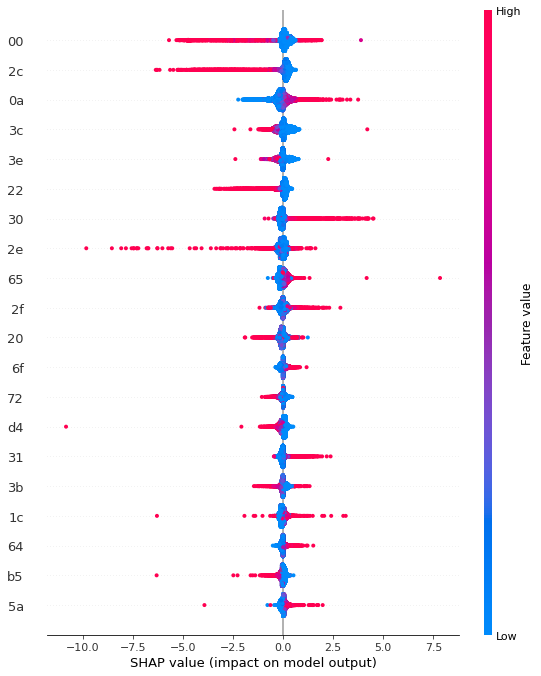

In [12]:
shap.summary_plot(shap_values[0], df_train)

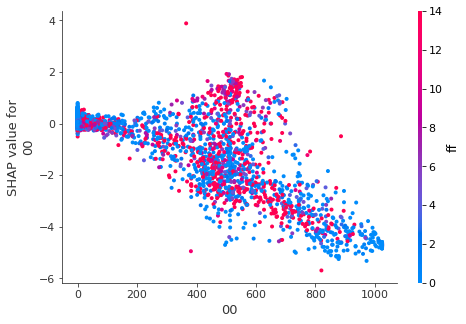

In [13]:
shap.dependence_plot('00', shap_values[0], df_train, interaction_index='ff')

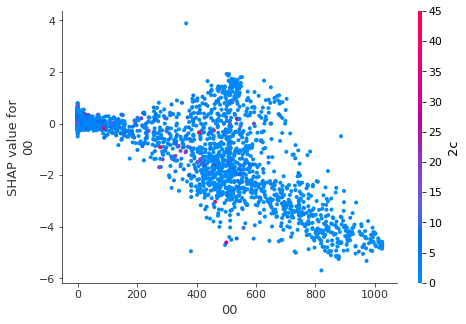

In [14]:
shap.dependence_plot('00', shap_values[0], df_train, interaction_index='2c')

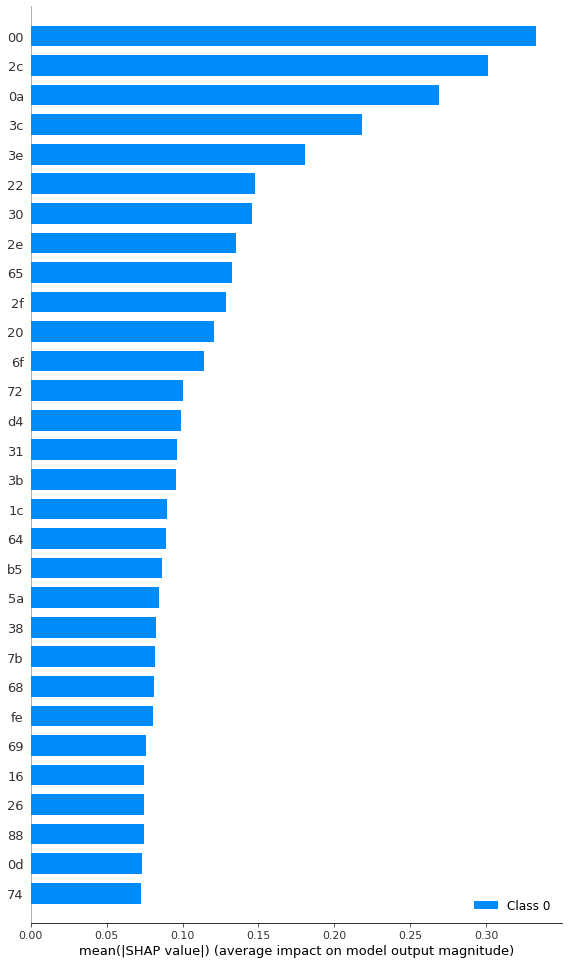

In [21]:
shap.summary_plot(shap_values, features=df_train, plot_type="bar", max_display=30)